1.Dependency setup


In [1]:
!pip install transformers datasets seaborn -q


2.Loading The Dataset, we are using IMDB dataset

In [5]:
import pandas as pd

df = pd.read_csv("/content/IMDB-Dataset.csv")

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


3.Cleaning Tags

In [6]:
import re

def clean_html(text):
    return re.sub(r"<.*?>", "", str(text))

df["review"] = df["review"].apply(clean_html)


4.Encoding the labels : 1 means positive, 0 for negative

In [7]:
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

df = df[["review", "label"]]
df.head()


,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


5. Splitting the Dataset into Train and Test

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")


Train samples: 40000, Test samples: 10000


6a. Visualise the Distribution

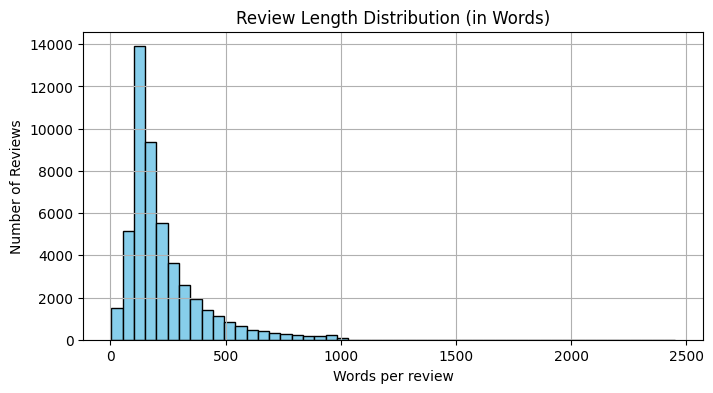

In [9]:
import matplotlib.pyplot as plt

review_lengths = df["review"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Review Length Distribution (in Words)")
plt.xlabel("Words per review")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


6b. Sentiment Distribuiton

<ipython-input-10-3724548471>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"].map({0: "Negative", 1: "Positive"}), palette="Set2")


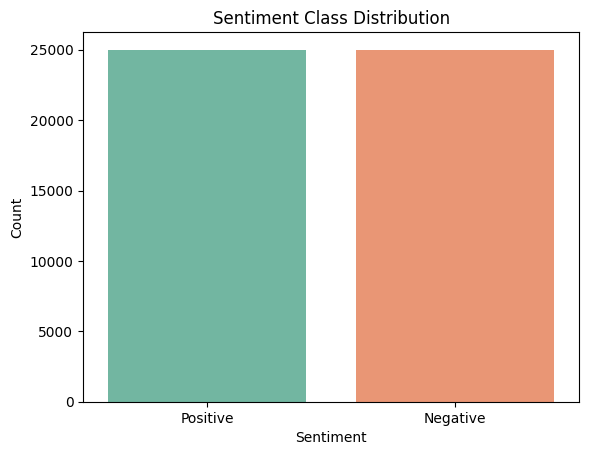

In [10]:
import seaborn as sns

sns.countplot(x=df["label"].map({0: "Negative", 1: "Positive"}), palette="Set2")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


7. Tokenizer setup

In [11]:
from transformers import (
    BertTokenizer, DistilBertTokenizer, RobertaTokenizer
)

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Function For Tokenization

In [12]:
def tokenize_texts(texts, tokenizer, max_len=256):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )


8. Tokenizor the Train and Test sets

In [13]:
# Tokenize train and test for each model
bert_train_encodings = tokenize_texts(train_texts, bert_tokenizer)
bert_test_encodings = tokenize_texts(test_texts, bert_tokenizer)

distilbert_train_encodings = tokenize_texts(train_texts, distilbert_tokenizer)
distilbert_test_encodings = tokenize_texts(test_texts, distilbert_tokenizer)

roberta_train_encodings = tokenize_texts(train_texts, roberta_tokenizer)
roberta_test_encodings = tokenize_texts(test_texts, roberta_tokenizer)


In [23]:
train_labels = train_labels[:2000]
test_labels = test_labels[:500]


Dataset class and organizing them for each models

In [24]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: val[idx] for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}


# BERT
bert_train_dataset = IMDbDataset(bert_train_encodings, train_labels)
bert_test_dataset = IMDbDataset(bert_test_encodings, test_labels)

# DistilBERT
distilbert_train_dataset = IMDbDataset(distilbert_train_encodings, train_labels)
distilbert_test_dataset = IMDbDataset(distilbert_test_encodings, test_labels)

# RoBERTa
roberta_train_dataset = IMDbDataset(roberta_train_encodings, train_labels)
roberta_test_dataset = IMDbDataset(roberta_test_encodings, test_labels)



9. Defining our Evaluation Metrics

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


10. Training Setup

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)


11. BERT MODEL TRAINING

In [27]:
from transformers import BertForSequenceClassification, Trainer

bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    compute_metrics=compute_metrics
)

bert_trainer.train()

results_bert = bert_trainer.evaluate()
print("\n BERT Evaluation Metrics:")
for key, value in results_bert.items():
    print(f"{key}: {value:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.323100



 BERT Evaluation Metrics:
eval_loss: 0.3825
eval_accuracy: 0.9040
eval_precision: 0.8842
eval_recall: 0.9271
eval_f1: 0.9051
eval_runtime: 7.2821
eval_samples_per_second: 68.6620
eval_steps_per_second: 8.6510
epoch: 2.0000


12. DistilBERT MODEl TRAINING

In [29]:
from transformers import DistilBertForSequenceClassification, Trainer

# Load the model
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Trainer setup
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_train_dataset,
    eval_dataset=distilbert_test_dataset,
    compute_metrics=compute_metrics
)

# Train
distilbert_trainer.train()

# Evaluate
results_distilbert = distilbert_trainer.evaluate()
print("\n DistilBERT Evaluation Metrics:")
for key, value in results_distilbert.items():
    print(f"{key}: {value:.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.348400



 DistilBERT Evaluation Metrics:
eval_loss: 0.3889
eval_accuracy: 0.8840
eval_precision: 0.8795
eval_recall: 0.8866
eval_f1: 0.8831
eval_runtime: 3.7019
eval_samples_per_second: 135.0650
eval_steps_per_second: 17.0180
epoch: 2.0000


13. RoBERTa MODEL TRAINING

In [30]:
from transformers import RobertaForSequenceClassification, Trainer

# Load model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Set up Trainer
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=roberta_train_dataset,
    eval_dataset=roberta_test_dataset,
    compute_metrics=compute_metrics
)

# Train
roberta_trainer.train()

# Evaluate
results_roberta = roberta_trainer.evaluate()
print("\n RoBERTa Evaluation Metrics:")
for key, value in results_roberta.items():
    print(f"{key}: {value:.4f}")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.406500



 RoBERTa Evaluation Metrics:
eval_loss: 0.2901
eval_accuracy: 0.9100
eval_precision: 0.9244
eval_recall: 0.8907
eval_f1: 0.9072
eval_runtime: 7.0219
eval_samples_per_second: 71.2060
eval_steps_per_second: 8.9720
epoch: 2.0000


In [31]:
import pandas as pd

results_table = pd.DataFrame({
    "Model": ["BERT", "DistilBERT", "RoBERTa"],
    "Accuracy": [
        results_bert["eval_accuracy"],
        results_distilbert["eval_accuracy"],
        results_roberta["eval_accuracy"]
    ],
    "F1 Score": [
        results_bert["eval_f1"],
        results_distilbert["eval_f1"],
        results_roberta["eval_f1"]
    ],
    "Precision": [
        results_bert["eval_precision"],
        results_distilbert["eval_precision"],
        results_roberta["eval_precision"]
    ],
    "Recall": [
        results_bert["eval_recall"],
        results_distilbert["eval_recall"],
        results_roberta["eval_recall"]
    ]
})

results_table = results_table.round(4)

results_table


,Model,Accuracy,F1 Score,Precision,Recall
0,BERT,0.904,0.9051,0.8842,0.9271
1,DistilBERT,0.884,0.8831,0.8795,0.8866
2,RoBERTa,0.910,0.9072,0.9244,0.8907
